Top 10 bridge nodes:
Node: CFS_3, Bridge Centrality: 39
Node: CFS_2, Bridge Centrality: 32
Node: CFS_10, Bridge Centrality: 23
Node: CFS_12, Bridge Centrality: 22
Node: BDI_Pessimism, Bridge Centrality: 19
Node: BDI_Worthlessness, Bridge Centrality: 18
Node: BDI_Past_Failure, Bridge Centrality: 18
Node: LSAS_11, Bridge Centrality: 17
Node: LSAS_2, Bridge Centrality: 16
Node: LSAS_7, Bridge Centrality: 16


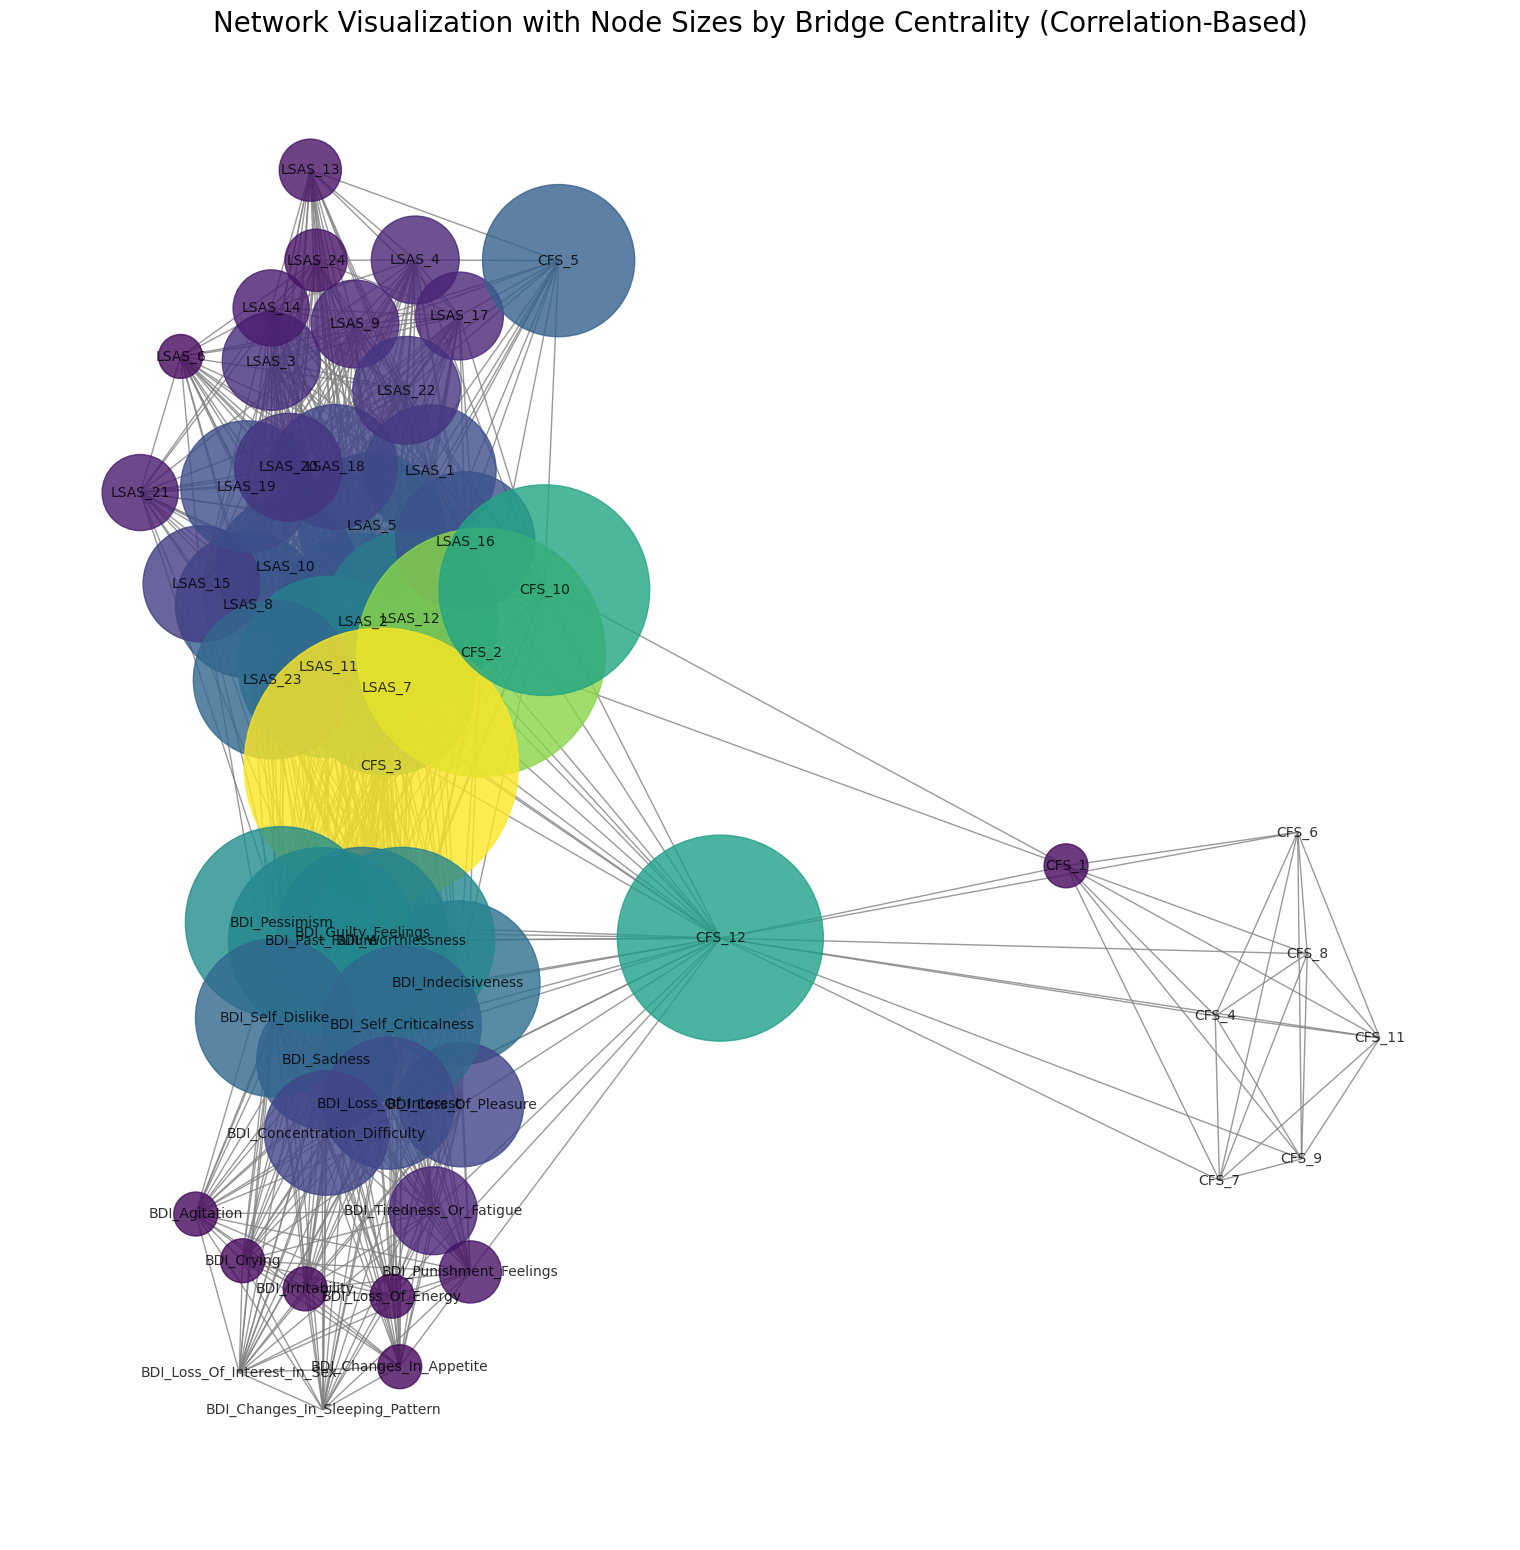

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load your dataset into a DataFrame (assuming df is your raw data)
df = pd.read_csv(r"C:\Users\MadiL\Thesis CodeBase\Cross-Sectional\lsas_together.csv")

# Identify relevant columns
lsas_columns = [col for col in df.columns if "LSAS" in col]
cfs_columns = [col for col in df.columns if "CFS" in col]
bdi_columns = [col for col in df.columns if "BDI" in col]

# Subset the dataframe to include only LSAS, CFS, and BDI columns
df_subset = df[lsas_columns + cfs_columns + bdi_columns].copy()

# Reverse score specific CFS questions
reverse_columns = ['CFS_2', 'CFS_3', 'CFS_5', 'CFS_10']
df_subset[reverse_columns] = 7 - df_subset[reverse_columns]

# Reverse the direction of all CFS columns
df_subset[cfs_columns] = df_subset[cfs_columns] * -1

# Standardize LSAS, CFS, and BDI columns
def standardize(df_column):
    return (df_column - df_column.mean()) / df_column.std()

df_subset[lsas_columns] = df_subset[lsas_columns].apply(standardize)
df_subset[cfs_columns] = df_subset[cfs_columns].apply(standardize)
df_subset[bdi_columns] = df_subset[bdi_columns].apply(standardize)

# Create a new DataFrame containing all the standardized individual items
df_standardized = df_subset[lsas_columns + cfs_columns + bdi_columns]

# Step 1: Correlation matrix
correlation_matrix = df_standardized.corr()

# Step 2: Create a network graph from the correlation matrix
# Threshold: Keep only significant edges (you can adjust the threshold as needed)
threshold = 0.3  # Example threshold, can be adjusted
G = nx.Graph()
for i, col1 in enumerate(correlation_matrix.columns):
    for j, col2 in enumerate(correlation_matrix.columns):
        if i < j and abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(col1, col2, weight=correlation_matrix.iloc[i, j])

# Step 3: Calculate bridge centrality (for bridging symptoms)
def calculate_bridge_centrality(G, scale_groups):
    """
    Calculate bridge centrality for nodes connecting different scale groups.

    Parameters:
    - G: NetworkX graph
    - scale_groups: A dictionary where keys are scale names and values are lists of nodes belonging to each scale

    Returns:
    - bridge_centrality: A dictionary with nodes as keys and bridge centrality scores as values
    """
    bridge_centrality = {node: 0 for node in G.nodes()}
    
    # Iterate over all edges
    for node1, node2 in G.edges():
        group1 = next((scale for scale, nodes in scale_groups.items() if node1 in nodes), None)
        group2 = next((scale for scale, nodes in scale_groups.items() if node2 in nodes), None)
        
        # If the nodes belong to different groups, increment bridge centrality
        if group1 != group2:
            bridge_centrality[node1] += 1
            bridge_centrality[node2] += 1
    
    return bridge_centrality

# Example usage of bridge centrality calculation
# Define scale groups (modify according to your dataset)
scale_groups = {
    'LSAS': [col for col in df_standardized.columns if 'LSAS' in col],
    'BDI': [col for col in df_standardized.columns if 'BDI' in col],
    'CFS': [col for col in df_standardized.columns if 'CFS' in col]
}
bridge_centrality_scores = calculate_bridge_centrality(G, scale_groups)

# Display top bridge nodes
top_bridge_nodes = sorted(bridge_centrality_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 bridge nodes:")
for node, score in top_bridge_nodes:
    print(f"Node: {node}, Bridge Centrality: {score}")

# Visualize the graph with bridge centrality
node_sizes = [1000 * bridge_centrality_scores[node] for node in G.nodes()]
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    cmap=plt.cm.viridis,
    node_color=list(bridge_centrality_scores.values()),
    font_size=10,
    font_color='black',
    edge_color='gray',
    alpha=0.8
)
plt.title('Network Visualization with Node Sizes by Bridge Centrality (Correlation-Based)', fontsize=20)
plt.show()
